In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd "drive/My Drive/Colab Notebooks/ADA_P4/data"

/content/drive/My Drive/Colab Notebooks/ADA_P4/data


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [4]:
def calculate_distance (lat1,lon1,lat2,lon2):
    """
    ################## Function we used in P2 and P4 to calculte distances ####################

    R : radius of earth : 6378.137 km
    lat1,lon1 : latitude and longitude of one user
    lat2,lon2 : latitude and longitude of other user
    """
    R = 6378.137
    # convert into radians
    lat1_rad=np.deg2rad(lat1)
    lat2_rad=np.deg2rad(lat2)
    lon1_rad=np.deg2rad(lon1)
    lon2_rad=np.deg2rad(lon2)
    
    #get difference of lattitude and difference of longitude
    delta_lat=lat2_rad-lat1_rad
    delta_lon=lon2_rad-lon1_rad
    
    #return formula Haversine formula
    a=((np.sin(0.5*delta_lat))**2)+np.cos(lat1_rad)*np.cos(lat2_rad)*((np.sin(0.5*delta_lon))**2)
    return 2*R*np.arcsin(np.sqrt(a))

def cont (x):
    if any(x.str.contains('Home','private')):return 1
    else : return 0

## **2) Friends checkins:**


- We want to find checkin patterns between friends gaherings.
- For that, we create a new dataframe, with whome we are are going to work for this whole part.
- We assume two friends have met together if they have checked in the same place with at most one hour difference. Since our dataframe is labeled and each place has its own id, we don't need to do any approximation on the checkin distance between friends.


In [5]:
def friends_gatherings(PROCEEDED_PATH,FRIENDSHIPS_PATH):
    """
    function to get dataframe where friends gathered
    INPUTS : 
    PROCEEDED_PATH : proceeded dataset path
    FRIENDSHIPS_PATH : friendships (edges) path
    OUTPUTS :
    1) dataframe that will be used for 1 futur plot, contains two columns : distance from home and probability of checkin
    This dataframe isn't limited to friends checkins and is used to see if there is any difference
    between considering friends gatherings or not
    2) Friends dataframe : contains the dataframe that will be used all this part for our studies.
    This dataframe contains the columns ['User ID','Venue ID','day','local time','lat','lon','place','country']

    In order to have a study that is the most accurate possible, we only work on users that checked in their homes at least once.
    That helps us make no approximation on the home location. 
    Moreover, our dataframe being large, we don't have the problem of not having enough data to study.

    In order to preserve memory, we will import the friendship dataframe in this function, we won't need it after that.
    """
    #Import two datasets
    df=pd.read_csv(PROCEEDED_PATH,parse_dates=['local time'])
    friendships=pd.read_csv(FRIENDSHIPS_PATH,sep='\t',encoding='latin-1',names=['User ID','User2 ID'], header=None)

    #clean edges dataframe : erase columns where the person following and the person followed is the same
    friendships=friendships[friendships['User ID']!=friendships['User2 ID']]

    print('begin getting homes')
    #create a new dataframe : df1 : used to find the home location of each user 
    #To do that,  we keep only the line where the user checked in their homes
    #Then, we get the means of checkin latitude and longitude for each user and each place checked in to find the home location
    # ==> The home location is the mean of checkins that were in the home of a user
    # We finally return only the three columns needed to perform the final merge to have the final 

    #We just initialize the two columns we need
    df1=df[['User ID','lat','lon','place']].rename(columns={'lat':'home lat','lon':'home lon'})
    df1=df1.groupby(['User ID','place'],as_index=False).\
        agg({'home lat':'mean','home lon':'mean'},axis='columns')
    df1=df1[df1['place'].str.contains('Home (private)',regex=False)][['User ID','home lat','home lon']]
    #df1 now contains for each user his home longitude and home latitude

    #We then perform a merge with the original dataset to integrate the home coordinates to the dataset
    df1=df1.merge(df[['User ID','Venue ID','day','local time','lat','lon','place','country']])
    df1['dist home']=calculate_distance(df1['lat'],df1['lon'],df1['home lat'],df1['home lon']).round()
    
    #Now we move to finding the final dataframe (the one we will use in the future)
    merged_friends=pd.DataFrame()
    chunksize=10**6
    numb_chunks=int(np.ceil(df1.shape[0]/chunksize))
    print('begin merging')
    #We work with chunks of size 10**6 each
    for i in range(numb_chunks):
        # Since we want the checkin place to be exactly the same for each user (have the same id),
        #we perform the merge on both the user and his checkin place (this procedure helped us save much memory and time)
        tmp_merge=df1[chunksize*i:chunksize*(i+1)].merge(friendships).\
                    merge(df1[['User ID','Venue ID','local time']],\
                          left_on=['User2 ID','Venue ID'],right_on=['User ID','Venue ID']).\
                    rename(columns={'dist home_x':'dist home'})

        #filter the tmp_merge with friends that checked in at most with one hour difference in the same place
        tmp_merge=tmp_merge[(np.abs((tmp_merge['local time_x']-tmp_merge['local time_y']).dt.total_seconds())<3600)]
        tmp_merge=tmp_merge.rename(columns={'local time_x':'local time'})

        #append the chunk to the final dataset
        merged_friends=merged_friends.append(tmp_merge[['day','local time','place','country','dist home']],ignore_index=True)
        
        if i==int(0.5*numb_chunks):print('halfway through merging')
    print('finished merging')
    return get_vects_plot(df1[['dist home']]),merged_friends

In [6]:
def get_vects_plot(df):
    """
    function to calculate the probability of checkin as a function of the distance
    Returns a dataframe where there are two columns: the distance from home and its probiability

    We begin by counting the number of checkin for each distance
    The we divide by the total number of counts to get a  probability.
    """
    #Create a new column, we will change it after
    #This new column will contain the probability of probability of checking in knowing the distance from home
    df1=df.copy()
    df1['proba dist']=df1['dist home']
    
    #'proba dist' column now contains the number of checkins for each distance
    df1=df1.groupby('dist home',as_index=False).count()[['dist home','proba dist']]

    #We divide the 'proba dist' column by the total number of checkins
    df1.loc[:,'proba dist']=df1['proba dist']/df1['proba dist'].sum()
    return df1[['dist home','proba dist']]

In [7]:
PROCEEDED_PATH='processed_dataset.csv'
FRIENDSHIPS_PATH='dataset_WWW_friendship_new.txt'
df_tot,df_friends=friends_gatherings(PROCEEDED_PATH,FRIENDSHIPS_PATH)

begin getting homes
begin merging
halfway through merging
finished merging


In [8]:
def apply_median(y,N=6):
    """
    ################  Function used also in P4 ################

    smoth curve using median
    y : to be plotted
    N : Number of items to use to smooth curve
    We choose not to do this process for small values because the curve is already smooth for small distances
    """
    y1=np.copy(y)
    
    for i in range (N,len(y)):
        if i>N:y1[i]=np.median(y[0:i+N])
        elif i<len(y)-N : y1[i]=np.median(y[i-N:i+N])
        else : y1[i]=np.median(y[i-N:len(y)])
    
    return y1

In [9]:
df_friends.head(2)

,day,local time,place,country,dist home
0,Sat,2012-05-05 19:24:41+00:00,Bar,US,161.0
1,Fri,2012-05-04 16:45:44+00:00,Airport,US,18.0


In [10]:
from scipy.optimize import curve_fit

In [11]:
def power_func(x, a, b):
    """
    function to compute a*(x^b)
    """
    return a * np.power( x,b)


In [12]:
df_plot_friends=get_vects_plot(df_friends)


In [13]:
df_plot_friends.head(2)

,dist home,proba dist
0,0.0,0.026705
1,1.0,0.081007


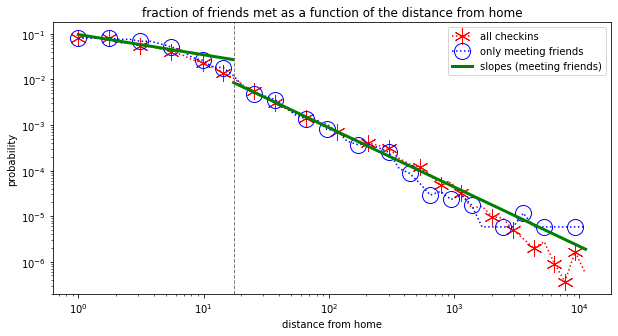

In [14]:
#The change_point isthe point where the behavior of the curves changes
#We find the chnge point empirically
change_point=16
#We create a logspace x_axis, we will use this vector for our futur plots
x_log=np.logspace(0,4.05,50)

#For both dataframes, we do an interpolation to find the corresponding values in the new logspace axis
#First, we begin by finding the interpolation functions for each vector,
#Then, we apply them of the dataframes
f_friends=interp1d(df_plot_friends['dist home'],df_plot_friends['proba dist'],kind='zero')
f_tot=interp1d(df_tot['dist home'],df_tot['proba dist'],kind='zero')

#y_friends,y_tot will be the vectors used for the plot.
#We don't apply the  median because we want to see the true curve, not a smoothed one.
y_friends=f_friends(x_log)
y_tot=f_tot(x_log)

#Since we want to approximate the parameters of our curves, we use scipy function 'fit_curve' 
#'params_friends1' are parameters for smaller distnces
#'params_friends2' are parameters for bigger distances
params_friends1,_=curve_fit(power_func,x_log[:change_point],y_friends[:change_point])
params_friends2,_=curve_fit(power_func,x_log[change_point:],y_friends[change_point:])

plt.figure(figsize=(10,5))
#Create marker style for both vectors and do the plots
#Plot all checkins
marker_style_all = dict(color='r', linestyle=':', marker=(6, 2, 0),markersize=16)
plt.loglog(x_log,y_tot,markevery=0.05, **marker_style_all,label='all checkins')

#Plot checkins proceeded only with friends
marker_style_friends = dict(color='blue', linestyle=':', marker='o',markersize=16,fillstyle='none')
plt.loglog(x_log,y_friends,markevery=0.05, **marker_style_friends,label='only meeting friends')
plt.xlabel('distance from home')
plt.ylabel('probability')
plt.title('fraction of friends met as a function of the distance from home')

#Now we proceed the plot of the approximation curve for smaller and larger distances
plt.loglog(x_log[change_point-1:], power_func(x_log[change_point-1:], params_friends2[0], params_friends2[1]),\
                  color='g',linewidth=3,label='slopes (meeting friends)')
plt.loglog(x_log[:change_point], power_func(x_log[:change_point], params_friends1[0], params_friends1[1]),\
                  color='g',linewidth=3)
plt.axvline(x_log[change_point-1],linestyle='--',linewidth=1, color='grey')
#plt.xticks([change_point+1],[round(x_log[change_point-1],0)])
plt.legend()

In [15]:
print('we have slopes of {} for distances inferior to 30km and slopes of {} for distances superior to 20km'.\
      format(round(params_friends1[1],2),round(params_friends2[1],2)))

we have slopes of -0.44 for distances inferior to 30km and slopes of -1.3 for distances superior to 20km


In [16]:
print('For distances inferior to 20km:\nThe distribution checkins knowingthe distance from home can ba approximates as :\
 P(x)={}*exp({}*x)'.format(round(params_friends1[0],2),round(params_friends1[1],2)))
print('For distances superior to 20km:\nthe distribution checkins knowingthe distance from home can ba approximates as :\
 P(x)={}*exp({}*x)'.format(round(params_friends2[0],2),round(params_friends2[1],2)))

For distances inferior to 20km:
The distribution checkins knowingthe distance from home can ba approximates as : P(x)=0.1*exp(-0.44*x)
For distances superior to 20km:
the distribution checkins knowingthe distance from home can ba approximates as : P(x)=0.35*exp(-1.3*x)


- We can also approximate the probability of moving from home knowing the distance with two equations:

$$ P(x)=
\begin{cases}
    0.1e^{-0.44x} & \text{if x<20 km}\\
    0.35e^{-1.3x} & \text{otherwise}
\end{cases}
$$

- We notice a change in the slope at a distance of approximately 20km distance from home. This behavior is similar to the one described in the paper. However, some differences are noticeble:  
1) The shift happened in a distance of 20km from home (vs 100km using other daasets)  
2) The slope are different than the ones described in the paper.  
Firstly, the slopes generally are smaller in our study compared to the ones found in the paper.  
Secondly, while the slope is smaller for small distances in the paper (-1.9 < -0.9), the behaviour is different in our study (-0.44 > -1.3)

- Finally, we notice in the plots that whether a user visited a friend or not does not make much differences in the overall behavior of checkins. We make the hypothesis that the behavior is the same and we test it. This hypothesis states that friends don't have any influence on a user's movement.
- Before going into that, we test whether our data is normally distributed or not. We perform a Kolmogorov Smirnov test, a test made to check whether a distribution is normal or not. The  Null hypothesis is that the sample comes from a normal distribution. and we reject it depending on the pvalue we get. The p-value is the probability of obtaining results that aren't more extereme than the ones observed, if we assume the null hypothesis is true.


In [18]:
from statsmodels.stats import diagnostic 
_, p_value_friends = diagnostic.kstest_normal(df_plot_friends['proba dist'], dist = 'norm')
_, p_value_tot = diagnostic.kstest_normal(df_tot['proba dist'], dist = 'norm')

In [19]:

print('Having the Null hypothesis that the data is derived from a normal distribution, we get :\n \t pvalue {} \
for the total checkins \n \t pvalue {} for the checkins with only friends'.format(p_value_tot,p_value_friends))

Having the Null hypothesis that the data is derived from a normal distribution, we get :
 	 pvalue 0.0 for the total checkins 
 	 pvalue 0.0 for the checkins with only friends


In [20]:
print('The dataframe containing only checkins with friends contains {} ligns\n\
The dataframe containing all checkins contains {} ligns'.format(df_plot_friends.shape[0],df_tot.shape[0]))

The dataframe containing only checkins with friends contains 3249 ligns
The dataframe containing all checkins contains 17483 ligns


$\Rightarrow$ Using the result found before, we conclude our data is not derived from a normal distribution

- Now we test whether the behaviour is the same or not for the two sets (considering all checkins vs considering only checkins with friends). This will help us know whether friends do have an influence on people's movement or not.
- We use the assertions below:  
1) We took two different samples from the same population.  
2) The data we're treating (probabilities) is not derived from a normal disrtibution (verified).  
3) Our samples are paired since they are derived from the same dataset  
$\Rightarrow$  We do a Wilcoxon test.  
To test the null hypothesis that there is no difference in behavior, we can apply the two-sided test.

- Our frames being of different shapes, we create a vector that will be used to make to comparision between the two frames and we use interpolations in order to have the the most precise values possible. 


In [21]:
x_log_exp=np.logspace(0,4.05,3000)

#For both dataframes, we do an interpolation to find the corresponding values in the new logspace axis
#First, we begin by finding the interpolation functions for each vector,
#Then, we apply them of the dataframes
f_friends_exp=interp1d(df_plot_friends['dist home'],df_plot_friends['proba dist'],kind='zero')
f_tot_exp=interp1d(df_tot['dist home'],df_tot['proba dist'],kind='zero')

#y_friends_exp,y_tot_exp will be the expanded (working with 3000 points) vectors used for the hypothesis testing
y_friends_exp=f_friends_exp(x_log)
y_tot_exp=f_tot_exp(x_log)

In [22]:
from scipy.stats import wilcoxon

In [23]:
_, p_value = wilcoxon(np.abs(y_friends_exp-y_tot_exp))
print('The pvalue found after performing a wilcoxon test is :',np.round(p_value,2))

The pvalue found after performing a wilcoxon test is : 0.0


- Having found a p-value of 0.0, we strongly reject our Null hypothesis.  
$\Rightarrow$ We conclude that friends do have a significant importance on a user's mobility. 

## **3) Places checkin patterns**
### I) Preprocessing :
- From now on, we only work with checkins with friends only : Every thing we will be studying are meetings between friends.
- We now go through our dataset and gategorize our places features into different categories:  
1) `Eat` : Going to eat with friends (restaurant , fast food ...)  
2) `Study` : Studying (being in school, universty ...)  
3) `Drink` : Having a drink with friends, going out ...  
4) `Culture` : Going to watch a movie, visit monuments ...  
5) `Home` : meet at someone's home  
6) `Move` : take public transports or travel to far places  
7) `Consume` : Visit stores, malls ...  
8) `Work` : Being in work's place  
9) `Entertain` : Go to a spa, hotel, beach,park ...  
10) `Sport` : practise sports together  

- We also categorize the days of the week into two types:  
1) `Working days` : Monday until Friday  
2) `Week end day` : Saturday and Sunday  

### II) Processing :
- We study the probability people meet in each category
- We compare normalized probabilities




In [32]:
df_classified=df_friends.copy()

#Change the name of variables to its type (will be used after)
df_classified.loc[df_classified['place'].str.\
                  contains('restaurant|Burger|pizza|Diner|food|Steakhouse|\
                  BBQ|Dessert|Ramen|Ice Cream|Fried|Sandwich|breakfast|snack|\
                  taco|hot|soup|wings',case=False),'place']='Eat'

df_classified.loc[df_classified['place'].str.\
                  contains('college|University|school|student',case=False),'place']='Study'

df_classified.loc[df_classified['place'].str.\
                  contains('coffee|Bar|Nightclub|pub|Lounge|Beer|tea|Nightlife',\
                           case=False),'place']='Drink'

df_classified.loc[df_classified['place'].str.\
                  contains('multiplex|Movie|Theater|concert|Music|historic|arts|\
                  Museum|library|Monument|temple|art',case=False),'place']='Culture'

df_classified.loc[df_classified['place'].str.\
                  contains('Home|Residential|Building',case=False),'place']='Home'

df_classified.loc[df_classified['place'].str.\
                  contains('station|airport|subway|travel|boat|bus',case=False),'place']='Move'

df_classified.loc[df_classified['place'].str.\
                  contains('store|mall|plaza|shop|boutique|market',case=False),'place']='Consume'

df_classified.loc[df_classified['place'].str.\
                  contains('work|office|Startup|professional',case=False),'place']='Work'

df_classified.loc[df_classified['place'].str.\
                  contains('soccer stadium|Entertainment|Outdoor|beach|park|event|\
                  Arcade|resort|hotel|spa|Casino',case=False),'place']='Entertainement'

df_classified.loc[df_classified['place'].str.\
                  contains('soccer field|sport|gym|stadium|surf|pool|golf|\baseball',\
                           case=False),'place']='Sport'

#Change the name of a day to its type (work day or week end)
df_classified.loc[df_classified['day'].str.contains('mon|tue|wed|thu|fri',case=False),'day']='Work day'
df_classified.loc[df_classified['day'].str.contains('sat|sun',case=False),'day']='Week end'

#Keep only the place types we mentioned before 
df_classified=df_classified.loc[df_classified['place'].str.contains('sport|Entertainement|Work|Consume|Move|Home|Culture|Drink|Study|Eat',case=False),:]
df_places=df_classified.groupby(['place','day'],as_index=False).agg({'country':'size'}).\
                sort_values(by='country',ascending=False)[['place','day','country']].\
                rename(columns={'country':'numb checkins','place':'place type','day':'day type'})
#df1.groupby('place_x').count().sort_values(by='day_x',ascending=False).head(50)

In [33]:
df_classified.head(2)

,day,local time,place,country,dist home
0,Week end,2012-05-05 19:24:41+00:00,Drink,US,161.0
1,Work day,2012-05-04 16:45:44+00:00,Move,US,18.0


In [34]:
df_places.head(2)

,place type,day type,numb checkins
17,Study,Work day,41063
7,Eat,Work day,16859


- Now we move to visualizing the distributions :

Text(0.5, 1.0, 'meeting patterns between friends')

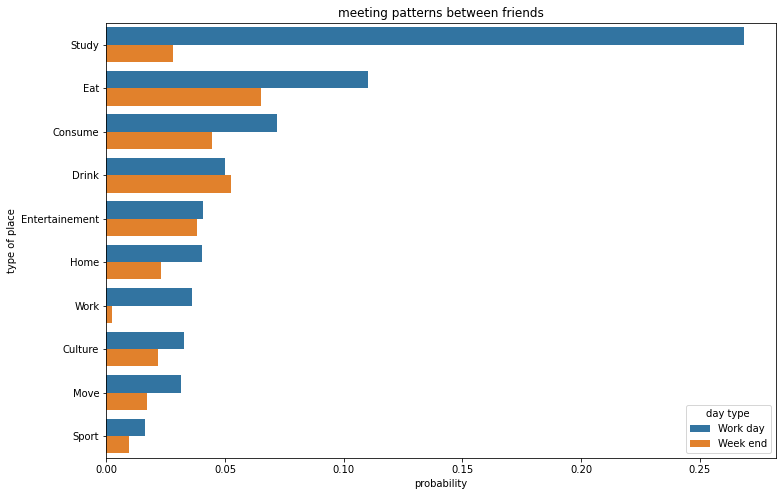

In [35]:
plt.figure(figsize=(12,8))
sns.barplot(x=df_places['numb checkins']/df_places['numb checkins'].sum(),\
            y=df_places['place type'],orient='h',hue=df_places['day type'])
plt.xlabel('probability')
plt.ylabel('type of place')
plt.title('meeting patterns between friends')

- The visualization above shows us that people are the most likely to be studying. This observation can be explained by the fact that students are the most likely to use sociaal media, so the most number of checkins can be found among students.
- However, we can't draw more conlusions because we have to take into account that there are 5 work days and 2 week end days in a week. $\rightarrow$ In order to be able to compare and study people's checkins, we normalize by the number of days each probability.  
- We will :  
1) Divide each probability that any event occured in a working day by 5  
2) Divide each probability that any event occured in a week end day by 2  
3) Get the normalized difference (normalized probability that a user checks in in a working day - normalized probability that a user checks in in a week end day)  
4) Divide the result by the probability of occurence in a work day to have a ratio.  
The final equation we will have is (for each place):
$$
final ratio = \frac{\frac{P_{workday}}{5}-\frac{P_{workend}}{2}}{\frac{P_{weekday}}{5}}
$$

- In the end:  
1)If this difference is positive : people are more likely to checkin in the place in a working day  
2)If this difference is negative : people are more likely to checkin in the place in a week end day  
3)The absolute value gives us the magnitude of the absolute ratio


In [36]:
def ratio (x):
    """
    Function to get difference between items atn then normalize
    Since x contains one negative (week end) and one positive (work day) value,
    max(x) is the value  of probability for a working day
    """
    return sum(x)/max(x)

In [37]:
#df4=df_classified.copy()
#normalize to have proba/day and then take the difference between the items:

#First, we divide by the number of days and set week end probabilities to be negative values 
#So that we perform a sum after
df_places.loc[df_places['day type'].str.contains('Week|end',case=False),'numb checkins']=\
                            -df_places.loc[df_places['day type'].str.\
                                               contains('Week|end',case=False),'numb checkins']/2

df_places.loc[df_places['day type'].str.contains('Work|day',case=False),'numb checkins']=\
                            df_places.loc[df_places['day type'].str.\
                                              contains('Work|day',case=False),'numb checkins']/5
#Now we groupby the place type and get the ratio we need                                              
df_places=df_places.groupby('place type',as_index=False).\
                            agg({'numb checkins':ratio},axis='columns').\
                            sort_values(by='numb checkins',ascending=False)


Text(0.5, 1.0, 'meeting patterns between friends day week vs week end')

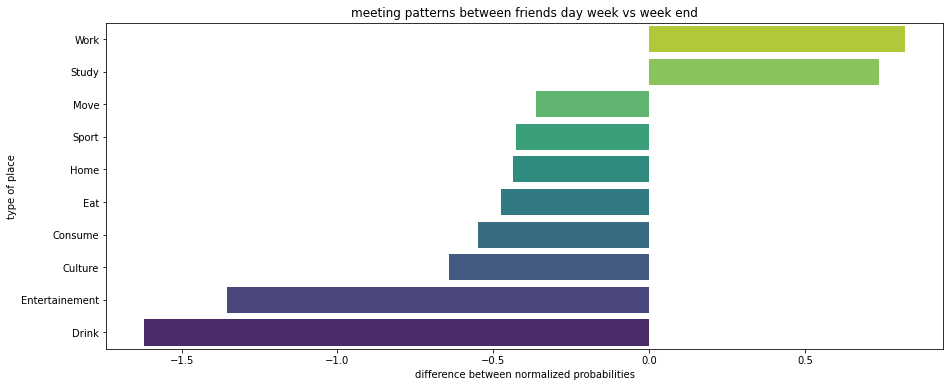

In [38]:
plt.figure(figsize=(15,6))
sns.barplot(x=df_places['numb checkins'],y=df_places['place type'],orient='h', palette='viridis_r')
plt.xlabel('difference between normalized probabilities')
plt.ylabel('type of place')
plt.title('meeting patterns between friends day week vs week end')

## **4) Times checkin patterns**

- In this final part, we will study the time friends meet.
We willclassify a day in two parts : afternoon and evening. 
- We consider afternoong hours of the day between 4h and 18h, and evening as other hours of the day

In [39]:
#In order to get our times, we substract 4 from total checkin hours
#Then we get the hours that are superior to 14
df_classified.loc[:,'evening']=(df_classified.loc[:,'local time'].dt.hour-4)>14

In [40]:
df_classified.head(2)

,day,local time,place,country,dist home,evening
0,Week end,2012-05-05 19:24:41+00:00,Drink,US,161.0,True
1,Work day,2012-05-04 16:45:44+00:00,Move,US,18.0,False


In [41]:
# We groupby the place type and then get the ratio of evening checkins
df_classified=df_classified.groupby('place',as_index=False).\
                      agg({'evening':'sum','country':'size'}).\
                      rename(columns={'country':'numb checkins'})
df_classified['ratio evening']=df_classified['evening']/df_classified['numb checkins']

#We sort values to have a good looking visualization
df_classified=df_classified.sort_values(by='ratio evening',ascending=False)

Text(0.5, 1.0, 'ratio of evening checkins')

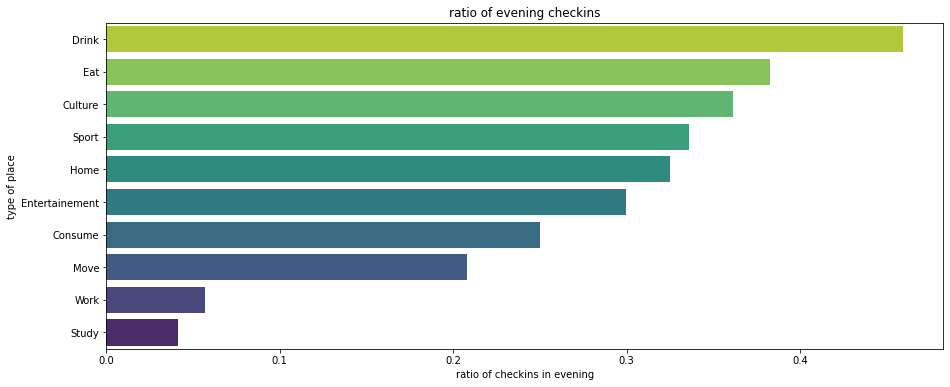

In [44]:
plt.figure(figsize=(15,6))
sns.barplot(x=df_classified['ratio evening'],y=df_classified['place'],orient='h', palette='viridis_r')
plt.xlabel('ratio of checkins in evening')
plt.ylabel('type of place')
plt.title('evening checkins of different places')

### III) Conclusions :
- People tend to meet their friends more in work or study places during the week. This can be explained by the fact that people usually have their coworkers and classmates as friends on social media. Studying or working is part of people's obligations and these are task are generally proceeded during the week
- However, when it comes to free time (week end for most of people), people choose to meet their friends in diverting places (every other category that doesn't involve working or studying). Specifically, people are the most likely to go out in weekend to have drinks or to entertainement places.
- Finally, people tend to spend their day working and studying, and then spend their evening and night in diverting places (eating, having drinks)